# Spectral Relaxation for K-means Clustering - Code

Josipa Radnić, Tea Maričić, Lara Milić, Eleonora Detić

#### 1. Matrična formulacija k sredina

Prvo ćemo presložiti matricu podataka(**A**) na način da združimo one elemente koji pripadaju istom klasteru i napravimo od njih blokove. Nakon toga, pomoću kreiranih blokova, računamo broj elementa klastera(**$s_i$**) i nove centroide (**$m_i$**). Potom kreiramo matricu X pomoću jediničnih vektora i $s_i$ na način koji smo opisali na predavanjima. Na kraju, preostaje ponovo inverzno djelovati istom permutacijom na matricu $X$ kako bismo dobili $\tilde{X}$ koja sadrži informacije o pripadnosti elementa početnoj particiji.

In [47]:
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

def matrix_formulation_Kmeans(A, D, k): 
    #A is data matrix
    #D is list of correct clasters for columns of A
    #k is number of clasters
    
    new_A = np.empty([A.shape[0],0])
    s_i = np.empty(k, dtype=int) 
    m_i = np.empty([A.shape[0],k])
    permutation = np.empty(0,) 

    for i in range(k):
        A_i = A[:, np.where(D == i)[1]] 
        permutation = np.append(permutation, np.where(D == i)[1], axis=0) 
        new_A = np.append(new_A, A_i, axis=1)
        s_i[i] = np.where(D == i)[1].shape[0]
        e = np.ones(s_i[i])
        m_i[:,i] = (1/s_i[i]) * np.matmul(A_i, e) 
    
    X = np.zeros([A.shape[1],k])

    for i in range(k):
        if( i == 0):
            X[i:s_i[i], 0] = 1/s_i[1]
        else:
            X[ s_i[0:i].sum() : s_i[0:i].sum() + s_i[i], i] = 1/s_i[i-1]

    X_tilde = np.zeros([A.shape[1],k])

    for i in range(X.shape[0]):
        index = list(permutation).index(i)  
        X_tilde[int(permutation[i]), :] = X[i, :] 

    start_partition = np.empty(D.shape[1], dtype=int)

    for i in range(X.shape[0]):
        start_partition[i] = int(np.where(X_tilde[i, :] != 0)[0])
    
    start_partition = np.reshape(start_partition, (D.shape[1],1))
    accuracy = accuracy_score(start_partition, np.transpose(D))
    return accuracy

#### 2.1 K-means algoritam 1

U ovom poglavlju navodimo učinkovitu verziju k-means algoritma za klasteriranje koristeći metode linearne algebre.

In [48]:
def K_means_1(A_train, A_test, D_train, D_test, k): 
    # A_train and A_test are data matrix
    # D_train and D_test are arrays
    # k is number of clasters
    
    base_for_k_elements = dict()
    
    for i in range (k):
        ii = [j for j, x in enumerate(D_train) if x == i] 
        B = A_train[:,ii]
        U, S, V = np.linalg.svd(B)
        base_for_k_elements[i] = U[:, 0:k]
    
    solution = np.zeros(len(D_test))
    
    for i in range (len(D_test)):
        min_distance = np.inf 
        claster = 0
        for j in range (0,k):
            distance = np.linalg.norm(A_test[:,i] - np.dot(np.dot(base_for_k_elements[j], base_for_k_elements[j].T),A_test[:,i]))
            if (distance < min_distance):
                min_distance = distance
                claster = j 
        solution[i] = claster
    
    return accuracy_score(solution, D_test)

#### 2.2 K-means algoritam 2

U ovom poglavlju navodimo jednostavnu, standardnu verziju k-means algoritma koja klasterira podatke.

In [49]:
def K_means_2(A, starting_partition, k, epsilon): 
    #A is data frame, one data is one present as one column
    #starting_partition is starting partition, usually random
    #k is number of clasters
    #epsilon is small number, stop criterion
    
    A.columns = starting_partition
    partition = starting_partition

    number_of_iteration = 0
    Q_of_partition = np.inf

    while(Q_of_partition > epsilon):
    
        number_of_iteration += 1

        s_i = np.unique(partition, axis=0, return_counts=True)[1]
        a_i = A.groupby(level=0,axis=1).sum().add_suffix('. centroid')
        m_i = a_i / s_i 
    
        Q_of_partition_before = 0
        for i in range(A.shape[1]):
            Q_of_partition_before  += np.linalg.norm((A.iloc[:,i] - m_i.iloc[:,A.columns[i]]))
        
        
        for i in range(A.shape[1]): 
            distance_final = np.inf
            for j in range(0, m_i.shape[1]):
                distance = np.linalg.norm((A.iloc[:,i] - m_i.iloc[:,j]))
                if(distance < distance_final):
                    distance_final = distance
                    tmp = list(A.columns)
                    tmp[i] = j
                    A.columns = tmp 
                
        partition = A.columns.values
    
        Q_of_partition_after = 0
        for i in range(A.shape[1]):
            Q_of_partition_after  += np.linalg.norm((A.iloc[:,i] - m_i.iloc[:,A.columns[i]]))
    
        Q_of_partition = Q_of_partition_before - Q_of_partition_after

    return number_of_iteration, m_i, A.columns


#### 3.1 Spektralna relaksacija

Koristeći spektralnu relaksaciju, cilj je smanjiti  dimenzije matrice A, ali svejedno očuvati sve potrebne informacije. Koristeći rezulate članka, vidimo da je dovoljno uzeti samo prvih k svojstvenih vektora koji odgovaraju k najvećim svojstvenim vrijednostima. Na taj način formiramo matricu X_k na čije retke primjenjujemo k-means. Svaki podatak više nije $m \times 1$, već $k \times 1$.

In [50]:
from scipy.linalg import eigh
import numpy as np

def spectral_relaxation(A,k):
    #A is data matrix, one column is one data

    eigenvalues, eigenvectors = eigh(np.transpose(A) @ A) 
    
    eigenvalues = eigenvalues[A.shape[1]-k:A.shape[1]][::-1] 
    X_k = np.flip(eigenvectors[:, (A.shape[1]-k):A.shape[1]] ,axis=1)
    
    return X_k

#### 3.2 QR faktorizacija

Daljni pokušaji poboljšanja k-means algoritma tiču se početne particije. Naime, voljeli bismo nekako dobiti najbolju moguću početnu particiju. Prije je bila ona bila random, sada bismo je voljeli nekako specificirati i reći da imamo najbolju moguću. Šta god "najbolje moguće" značilo.

In [51]:
def QR_for_starting_partition(A,k):
    #A is data matrix, one column is one data
    
    X_k = spectral_relaxation(A,k)
    X_k = np.transpose(X_k)

    Q, R, P = scipy.linalg.qr(X_k, pivoting = True)
    P_ = np.zeros([A.shape[1],A.shape[1]])
    for i in range(A.shape[1]):
        P_[i,P[i]] = 1

    R_11 = R[0:k, 0:k]
    R_12 = R[0:k, k:R.shape[1]]
    I = np.eye(k, dtype=int)
    R = np.matmul(np.linalg.inv(R_11), R_12)

    R_kapa = np.append(I,R,axis=1)  @  np.transpose(P_)
    R_kapa = np.absolute(R_kapa)
    
    return np.argmax(R_kapa, axis=0)

#### 4. 1 K-means koristeći spektralnu relaksaciju

In [56]:
def p_K_means(A,k,epsilon):
    
    X_k = spectral_relaxation(A, k)
    X_k = np.transpose(X_k)
    
    while True: 
        starting_partition = np.random.randint(0, k, A.shape[1])
        s_i = np.unique(starting_partition, axis=0, return_counts=True)[1]
        if len(s_i) == k:
            break
    
    return K_means_2(pd.DataFrame(X_k), starting_partition, k, epsilon)
    

#### 4.2 K-means koristeći QR

In [58]:
def p_QR(A,k,epsilon):
    
    X_k = spectral_relaxation(A,k)
    X_k = np.transpose(X_k)
    
    starting_partition = QR_for_starting_partition(A, k)

    
    return K_means_2(pd.DataFrame(X_k), starting_partition, k, epsilon)

#### 4.3 K-means za prediktiranje

In [62]:
from sklearn.model_selection import train_test_split
import statistics
from statistics import mode

def K_means_predict(A, D, k, epsilon):
    #A is data matrix, one column is one data
    #D is array of real clasters
    #k is number of clasters
    #epsilon is stop criterion
    
    partition = np.array(p_QR(A,k,epsilon)[2])
    D_informations = np.vstack([D, partition]) 
    A_informations = np.vstack([A, partition])

    A_train, A_test, D_train, D_test = train_test_split(np.transpose(A_informations), np.transpose(D_informations), test_size=0.33, random_state=42)
    A_train = np.transpose(A_train)
    A_test= np.transpose(A_test)
    D_train = np.transpose(D_train)
    D_test = np.transpose(D_test)

    solution = np.zeros(D_test[0].shape[0])

    for i in range(D_test[0].shape[0]):
        claster = D_test[1][i]
        index = np.where(A_train[-1, :] == claster)[0]
        numbers = D_train[0][index]
        if(numbers.size != 0 ):
            solution[i] = mode(numbers)
    
    return np.sum(D_test[0] == solution) / D_test[0].shape[0]   

#### 5.1 Podaci - znamenke

In [60]:
import scipy.io

mat_1 = scipy.io.loadmat('azip.mat')
A_digits = mat_1['azip'] 

mat_2 = scipy.io.loadmat('dzip.mat')
D_digits = mat_2['dzip']

k_digits = 10 

epsilon_digits = 1e-8

In [119]:
import time
start_time = time.time()

K_means_predict(A_digits[:,0:100], D_digits[:,0:100], k_digits, epsilon_digits)

time_digits = time.time() - start_time

#### 5.2 Podaci - pacijenti

In [65]:
from sklearn.impute import SimpleImputer

df = pd.read_csv('data_arrhythmia.csv', delimiter=';')
df = df.replace('?', np.NaN)
imp = SimpleImputer(missing_values=np.nan, strategy='mean') 
idf = pd.DataFrame(imp.fit_transform(df))
idf.columns = df.columns
idf.index = df.index
df = idf
df.head()

,age,sex,height,weight,qrs_duration,p-r_interval,q-t_interval,t_interval,p_interval,qrs,...,KY,KZ,LA,LB,LC,LD,LE,LF,LG,diagnosis
0,75.0,0.0,190.0,80.0,91.0,193.0,371.0,174.0,121.0,-16.0,...,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,8.0
1,56.0,1.0,165.0,64.0,81.0,174.0,401.0,149.0,39.0,25.0,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,6.0
2,54.0,0.0,172.0,95.0,138.0,163.0,386.0,185.0,102.0,96.0,...,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,10.0
3,55.0,0.0,175.0,94.0,100.0,202.0,380.0,179.0,143.0,28.0,...,0.0,12.2,-2.2,0.0,0.0,0.4,2.6,34.6,61.6,1.0
4,75.0,0.0,190.0,80.0,88.0,181.0,360.0,177.0,103.0,-16.0,...,0.0,13.1,-3.6,0.0,0.0,-0.1,3.9,25.4,62.8,7.0


In [ ]:
A_pacients = np.transpose(np.array(df.iloc[:, :-1]))
D_pacients = np.array(df.iloc[:, -1])

k_pacients = 12
epsilon_pacients = 1e-8

In [120]:
import time
start_time = time.time()

K_means_predict(A_pacients, D_pacients, k_pacients, epsilon_pacients)

time_pacients = time.time() - start_time

#### 5.3 Podaci - odjevni predmeti

#opis ..

In [ ]:
PATH_TO_IMAGES_FOLDER = r'.\DataSetFashion\\'

slika = os.listdir('/Users/eleonoradetic/USPP/DataSetFashion')
n = len(slika)

131


In [117]:
import os
import numpy as np
import cv2

A_clothes = np.empty([12288,0])
D_clothes = np.zeros(131)
k_clothes = 3
epsilon_clothes = 1e-10

for i in range (n): 
        img = cv2.imread(os.path.join('/Users/eleonoradetic/USPP/DataSetFashion',slika[i]))
        
        if((slika[i])[-5] == 'C' or (slika[i])[-6] == 'C'): 
                D_clothes[i] = 1
        elif((slika[i])[-5] == 'T' or (slika[i])[-6] == 'T' ): 
                D_clothes[i] = 2
        else: # (slika[i][-5] == 'M' or slika[i][-6] == 'M' ): 
                D_clothes[i] = 3
                
        ims = cv2.resize(img, (64,64))
        ims1 = np.reshape(ims,(12288,1))
        
        A_clothes  = np.append(A_clothes, ims1, axis=1)


In [ ]:
K_means_predict(A_clothes, D_clothes, k_clothes, epsilon_clothes)

0.4318181818181818

#### 5.4 Podaci - točke

#### 6. Usporedba rezultata, zaključci

In [138]:
import matplotlib.pyplot as plt
from tqdm import tqdm

x = np.array([50,100,500,1000,1707])
y = np.zeros(len(x))

for i in tqdm(range(0, len(x))):
    y[i] = K_means_predict(A_digits[:,0:x[i]], D_digits[:, 0:x[i]], k_digits, epsilon_digits)

plt.bar(list(x), list(y*100), color = ["darkblue"])
plt.xlabel('Broj podataka - znamenka')
plt.ylabel('Točnost predikcije')
plt.grid(True)
plt.show()

 40%|████      | 2/5 [00:05<00:10,  3.36s/it]

100%|██████████| 6/6 [02:01<00:00, 20.23s/it]


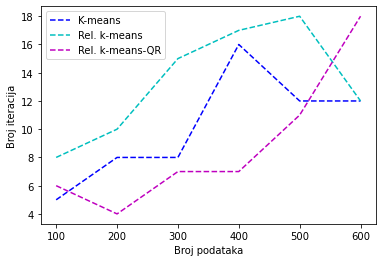

In [ ]:
x = np.array([100,200,300,400,500])
y_1 = np.zeros(len(x))
y_2 = np.zeros(len(x))
y_3 = np.zeros(len(x))


for i in tqdm(range(0,len(x))):
    A = A_digits[:, 0:x[i]]
    A = A.byteswap().newbyteorder()
    
    while True: 
        starting_partition = np.random.randint(0, k_digits, A.shape[1])
        s_i = np.unique(starting_partition, axis=0, return_counts=True)[1]
        if len(s_i) == k_digits:
            break
        
    y_1[i] = K_means_2(pd.DataFrame(A), starting_partition, k_digits, 1e-8)[0]
    

for i in tqdm(range(0,len(x))):
    y_2[i] = p_K_means(A_digits[:, 0:x[i]], k_digits, 1e-8)[0]
 
for i in tqdm(range(0,len(x))):
    y_3[i] = p_QR(A_digits[:, 0:x[i]], k_digits, 1e-8)[0]  
    

plt.plot(x, y_1, label = "K-means", color="b", linestyle='dashed')
plt.plot(x, y_2, label = "Rel. k-means", color="c", linestyle='dashed')
plt.plot(x, y_3, label = "Rel. k-means-QR", color="m", linestyle='dashed')
plt.xlabel("Broj podataka - znamenka")
plt.ylabel("Broj iteracija")

plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm


x = ['Znamenke', 'Pacijenti', 'Odjevni predmeti']
y = np.zeros(3)

y[0] = K_means_predict(A_digits, D_digits, k_digits, epsilon_digits)
y[1] = K_means_predict(A_pacients, D_pacients, k_pacients, epsilon_pacients)
y[2] = K_means_predict(A_clothes, D_clothes, k_clothes, epsilon_clothes)


plt.bar(x, list(y*100), color = ["darkblue", "skyblue", "blue"])
plt.ylabel('Točnost predikcije')
plt.grid(True)
plt.show()

KeyboardInterrupt: 

100%|██████████| 6/6 [02:21<00:00, 23.66s/it]


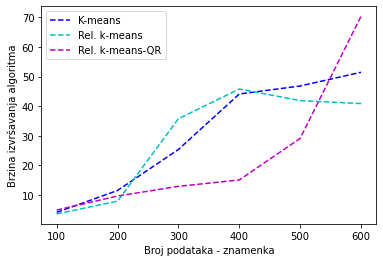

In [ ]:
import time
x = np.array([100,200,300,400,500])

time_K_means = np.zeros(len(x))
time_p_K_means = np.zeros(len(x))
time_p_QR_K_means = np.zeros(len(x))

for i in tqdm(range(0,len(x))):
    start_time = time.time() 
    A = A_digits[:, 0:x[i]]
    A = A.byteswap().newbyteorder()
    
    while True: 
        starting_partition = np.random.randint(0, k_digits, A.shape[1])
        s_i = np.unique(starting_partition, axis=0, return_counts=True)[1]
        if len(s_i) == k_digits:
            break
        
    K_means_2(pd.DataFrame(A), starting_partition, k_digits, 1e-8)
    
    time_K_means[i] = time.time() - start_time
    

for i in tqdm(range(0,len(x))):
    start_time = time.time() 
    p_K_means(A_digits[:, 0:x[i]], k_digits, 1e-8)[0]
    time_p_K_means[i] = time.time() - start_time
 
for i in tqdm(range(0,len(x))):
    start_time = time.time() 
    p_QR(A_digits[:, 0:x[i]], k_digits, 1e-8)[0]  
    time_p_QR_K_means[i] = time.time() - start_time
    

plt.plot(x, time_K_means, label = "K-means", color="b", linestyle='dashed')
plt.plot(x, time_p_K_means, label = "Rel. k-means", color="c", linestyle='dashed')
plt.plot(x, time_p_QR_K_means, label = "Rel. k-means-QR", color="m", linestyle='dashed')
plt.xlabel("Broj podataka - znamenka")
plt.ylabel("Brzina izvršavanja algoritma")

plt.legend()
plt.show()